<br></br>
# **Word / Doc 2 Vec**


<br></br>
# **1 Tensorflow 를 활용한 Word2Vec**

<br></br>
## **1.1 데이터 전처리**
베를린 선언문

In [1]:
f     = open('./data/베를린선언.txt', 'r')
texts_Berlin_raw = f.read()
f.close()
texts_Berlin = texts_Berlin_raw.split('\n\n')

In [2]:
import string
punct = string.punctuation
punct = [punct[i] for i in range(len(punct))]
punct = punct + ['\n', ')', '(']

for dump in punct: 
    texts_Berlin = [txt.replace(dump, '')    for txt in texts_Berlin]
print(len(texts_Berlin))

309


In [3]:
word_sequence = " ".join(texts_Berlin).split()
word_list     = " ".join(texts_Berlin).split()
word_list     = list(set(word_list))
word_dict     = {w: i for i, w in enumerate(word_list)}

<br></br>
## **1.2 Tensorflow  설정**
데이터 및 파라미터설정

In [4]:
import tensorflow as tf
import numpy as np

skip_grams = []
for i in range(1, len(word_sequence) - 1):
    target  = word_dict[word_sequence[i]]
    context = [word_dict[word_sequence[i-1]], word_dict[word_sequence[i+1]]]
    for w in context:
        skip_grams.append([target, w])

ImportError: No module named 'tensorflow'

In [ ]:
# skip-gram 데이터에서 무작위로 데이터를 뽑아 입력값과 출력값의 배치 데이터를 생성
def random_batch(data, size):
    random_inputs, random_labels = [], []
    random_index = np.random.choice(range(len(data)), size, replace=False)
    for i in random_index:
        random_inputs.append(data[i][0])    # target
        random_labels.append([data[i][1]])  # context word
    return random_inputs, random_labels

In [ ]:
training_epoch = 300
learning_rate  = 0.1
batch_size     = 20
embedding_size = 2   # 단어벡터 임베딩 차원 (x, y 2개만 출력)
num_sampled    = 15  # 모델의 nce_loss 샘플크기 (batch_size 보다 작아야 한다)
voc_size       = len(word_list) # 총 단어 갯수

<br></br>
## **1.3 Tensorflow  모델설정**
model Setting

In [ ]:
inputs = tf.placeholder(tf.int32, shape=[batch_size])
labels = tf.placeholder(tf.int32, shape=[batch_size, 1])

embeddings     = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
selected_embed = tf.nn.embedding_lookup(embeddings, inputs)
nce_weights    = tf.Variable(tf.random_uniform([voc_size, embedding_size], -1.0, 1.0))
nce_biases     = tf.Variable(tf.zeros([voc_size]))

In [ ]:
loss = tf.reduce_mean(
            tf.nn.nce_loss(nce_weights, nce_biases, labels, selected_embed, num_sampled, voc_size))
train_op = tf.train.AdamOptimizer(learning_rate).minimize(loss)

<br></br>
## **1.4 Tensorflow  Session 모델학습**
Session

In [ ]:
%%time
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    for step in range(1, training_epoch + 1):
        batch_inputs, batch_labels = random_batch(skip_grams, batch_size)
        _, loss_val = sess.run([train_op, loss],
                               feed_dict={inputs: batch_inputs,
                                          labels: batch_labels})
        if step % 30 == 0:
            print("loss at step ", step, ": ", loss_val)
    # with 구문 안에서는 sess.run 대신 간단히 eval() 함수를 사용할 수 있습니다.
    trained_embeddings = embeddings.eval()

<br></br>
## **1.5 Visualization**
Session

In [ ]:
%matplotlib inline
from matplotlib import font_manager, rc
font_fname = './data/D2Coding.ttf'     
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
for i, label in enumerate(word_list):
    x, y = trained_embeddings[i]
    plt.scatter(x, y)
    plt.annotate(label, xy=(x, y), xytext=(5, 2),
                 textcoords='offset points', ha='right', va='bottom')
plt.grid(True)
plt.show()

<br></br>
# **2. gensim | word2vec**
<br></br>
## **2.1 데이터 전처리**

In [5]:
%%time
# 텍스트를 한 줄씩 문법 tag를 추가한다
results, lines = [], texts_Berlin

# use Open Korean Text (p.k.a. Twitter)
# http://konlpy.org/en/latest/api/konlpy.tag/#okt-class
from konlpy.tag import Okt
twitter = Okt()


for line in lines:
    malist = twitter.pos(line, norm=True, stem=True)
    result = [ word[0]   for word in malist    # 어미/조사/구두점 제외
               if not word[1] in ["Eomi", "Josa", "Punctuation"] ]
    rl = (" ".join(result)).strip()
    results.append(rl)
    
texts_file = './data/Berlin.tagged'
with open(texts_file, 'w', encoding='utf-8') as fp:
    fp.write("\n".join(results))

CPU times: user 8.49 s, sys: 148 ms, total: 8.64 s
Wall time: 2.6 s


In [6]:
! cat ./data/Berlin.tagged | head -n 5

존경 하다 독일 국민 여러분
고국 계시다 국민 여러분
하울 젠 쾨르버 재단 이사 님 모드 전 동독 총리 님 비롯 내외 귀빈 여러분
먼저 냉전 분단 넘다 통일 이루다
그 힘 유럽 통합 국제 평화 선도 있다


<br></br>
## **2.2 Word 2 vec 객체 만들기**
gensim

In [7]:
# ! pip3 install gensim

In [8]:
%%time
from gensim.models import word2vec

data  = word2vec.LineSentence(texts_file)
model = word2vec.Word2Vec(data, size=200, window=10, hs=1, min_count=2, sg=1)
model.save("./data/Berlin.model")
print("model saved.")

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


model saved.
CPU times: user 804 ms, sys: 1.03 s, total: 1.83 s
Wall time: 552 ms


<br></br>
## **2.3 저장된 객체 활용**
gensim

In [9]:
from gensim.models import word2vec
model = word2vec.Word2Vec.load('./data/Berlin.model')
model.wv.most_similar(positive=['한반도'])

/home/yyoo/nltk/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('하다', 0.944922924041748),
 ('북한', 0.940086841583252),
 ('이다', 0.9364309310913086),
 ('것', 0.930040717124939),
 ('남북', 0.9211788177490234),
 ('있다', 0.9207656979560852),
 ('들', 0.9172158241271973),
 ('되다', 0.9125617742538452),
 ('적', 0.9120664000511169),
 ('선언', 0.9044978022575378)]

In [10]:
model.wv.most_similar(positive=['통일'])

/home/yyoo/nltk/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('하다', 0.8780206441879272),
 ('이다', 0.8711502552032471),
 ('것', 0.8687241077423096),
 ('적', 0.8644446730613708),
 ('북한', 0.8614990711212158),
 ('과정', 0.8598086833953857),
 ('남북', 0.8560356497764587),
 ('있다', 0.8543451428413391),
 ('한반도', 0.8468970060348511),
 ('‘', 0.8382730484008789)]

In [11]:
model.wv.most_similar(positive=['정치'])

/home/yyoo/nltk/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('교류', 0.910293459892273),
 ('분야', 0.8959566354751587),
 ('있다', 0.8938546180725098),
 ('하다', 0.8857982754707336),
 ('군사', 0.8830951452255249),
 ('상봉', 0.877606213092804),
 ('사업', 0.8757619857788086),
 ('북한', 0.8721091747283936),
 ('민간', 0.8684262037277222),
 ('선언', 0.8640038967132568)]

In [12]:
model.wv.most_similar(positive=['북한', '한반도'], 
                      negative=['전쟁'])

/home/yyoo/nltk/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('것', 0.8314428329467773),
 ('하다', 0.8292749524116516),
 ('이다', 0.8185296058654785),
 ('되다', 0.8165890574455261),
 ('들', 0.8083539605140686),
 ('적', 0.8068721890449524),
 ('남북', 0.8017648458480835),
 ('협력', 0.7996297478675842),
 ('있다', 0.796013593673706),
 ('분야', 0.7917640805244446)]

<br></br>
## **2.4 Visulaization**
gensim

In [13]:
# model.wv.vocab : { word: object of numeric vector }
vocab = list(model.wv.vocab)
X = model[vocab]

/home/yyoo/nltk/lib/python3.5/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [15]:
import pandas as pd
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])
df.head()

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


,x,y
군사,-18.987864,9.133384
전,-9.843158,2.988913
논의,0.244540,4.049938
마음,-3.391347,8.769960
정치,-19.051186,8.496626


/home/yyoo/nltk/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/yyoo/nltk/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['D2Coding'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


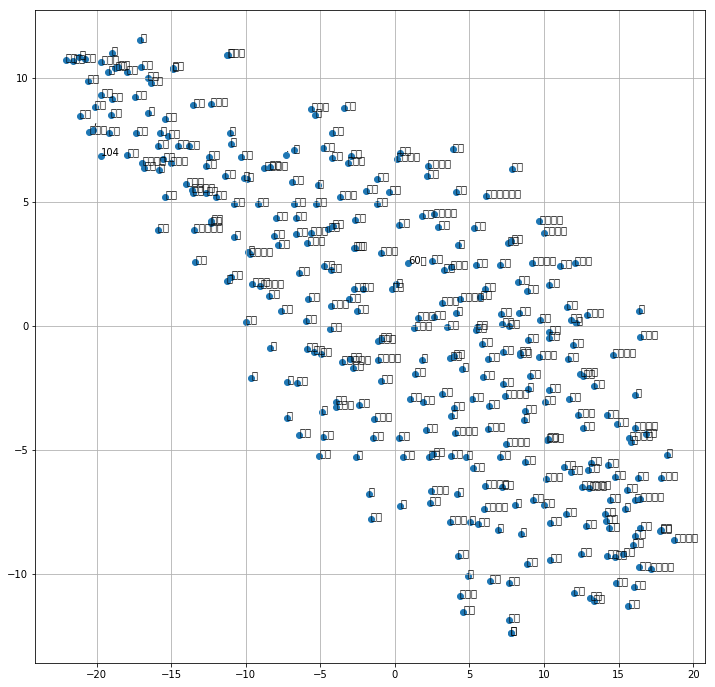

In [16]:
%matplotlib inline
from matplotlib import font_manager, rc
font_fname = './data/D2Coding.ttf'     
font_name = font_manager.FontProperties(fname=font_fname).get_name()
rc('font', family=font_name)

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,12))
plt.grid(True)
ax  = fig.add_subplot(1, 1, 1)
ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos)

<br></br>
# **3. gensim | doc2vec**
<br></br>
## **3.1 네이버 단어 전처리**
네이버 영화리뷰 단어모델 만들기

In [17]:
from konlpy.tag import Okt
twitter = Okt()

def read_data(filename):
    with open(filename, 'r') as f:
        data = [line.split('\t') for line in f.read().splitlines()]
    from random import randint
    random_data = [data[randint(1, len(data))]  for no in range(int(len(data)/10)) ]
    return random_data

def tokenize(doc):
  # norm, stem은 option 이었지만, konlpy 0.5 업데이트 이후로는 True 로 작업하자
  return ['/'.join(t) for t in twitter.pos(doc, norm=True, stem=True)]

In [18]:
%%time
from collections import namedtuple
train_data        = read_data('data/ratings_train.txt')
train_docs        = [(tokenize(row[1]), row[2]) for row in train_data[1:]]
TaggedDocument    = namedtuple('TaggedDocument', 'words tags')
tagged_train_docs = [TaggedDocument(d, [c]) for d, c in train_docs]

CPU times: user 39 s, sys: 308 ms, total: 39.4 s
Wall time: 34 s


In [19]:
from pprint import pprint
pprint(tagged_train_docs[0])

TaggedDocument(words=['4.44/Number', '맞추다/Verb'], tags=['0'])


<br></br>
## **3.2 doc2vec 파라미터 설정 및 학습**

In [20]:
%%time
from gensim.models import doc2vec
doc_vectorizer = doc2vec.Doc2Vec(vector_size=300, alpha=0.025, min_alpha=0.025, seed=1234)
doc_vectorizer.build_vocab(tagged_train_docs)

for epoch in range(10):
    doc_vectorizer.train(tagged_train_docs, 
                         total_examples = doc_vectorizer.corpus_count, 
                         epochs = doc_vectorizer.epochs)
    doc_vectorizer.alpha -= 0.002
    doc_vectorizer.min_alpha = doc_vectorizer.alpha 

# 학습이 완료된 모델의 데이터를 저장한다
doc_vectorizer.save('data/doc2vec.model')

CPU times: user 39.1 s, sys: 6.13 s, total: 45.3 s
Wall time: 27.7 s


<br></br>
## **3.3 doc2Vec 모델활용**

In [21]:
from gensim.models import doc2vec
from pprint import pprint
doc_vectorizer = doc2vec.Doc2Vec.load('data/doc2vec.model')

In [22]:
pprint(doc_vectorizer.wv.most_similar('공포/Noun'))

[('스릴러/Noun', 0.44871047139167786),
 ('개그/Noun', 0.4215414524078369),
 ('섞다/Verb', 0.39408808946609497),
 ('스페인/Noun', 0.3831770718097687),
 ('만화/Noun', 0.37883439660072327),
 ('사무라이/Noun', 0.3769323229789734),
 ('신파/Noun', 0.3761172294616699),
 ('싱겁다/Adjective', 0.3758915066719055),
 ('과정/Noun', 0.3723253905773163),
 ('햄버거/Noun', 0.36898237466812134)]


/home/yyoo/nltk/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [23]:
pprint(doc_vectorizer.wv.most_similar('공포영화/Noun'))

[('전쟁영화/Noun', 0.5102571845054626),
 ('올해/Noun', 0.4646482467651367),
 ('스릴러/Noun', 0.4571760296821594),
 ('자유/Noun', 0.4442580044269562),
 ('재난영화/Noun', 0.4371589720249176),
 ('스타/Noun', 0.4289533197879791),
 ('로코/Noun', 0.4109783470630646),
 ('햄버거/Noun', 0.40965110063552856),
 ('멜로영화/Noun', 0.406591534614563),
 ('시리즈/Noun', 0.40252164006233215)]


/home/yyoo/nltk/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [24]:
doc_vectorizer.wv.similarity('공포/Noun', 'ㅋㅋ/KoreanParticle')

/home/yyoo/nltk/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


0.10990191

In [25]:
pprint(doc_vectorizer.wv.most_similar(positive=['여자/Noun', '최악/Noun'], 
                                      negative=['남자/Noun']))

[('최고/Noun', 0.4056493043899536),
 ('만족스럽다/Adjective', 0.3560687005519867),
 ('놀랍다/Adjective', 0.33587944507598877),
 ('조작/Noun', 0.32012468576431274),
 ('최강/Noun', 0.31954425573349),
 ('하아/Exclamation', 0.30481386184692383),
 ('갑/Noun', 0.3022654354572296),
 ('권/Suffix', 0.30115318298339844),
 ('ㅄ/KoreanParticle', 0.2994678020477295),
 ('기세/Noun', 0.29650557041168213)]


/home/yyoo/nltk/lib/python3.5/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [26]:
doc_vectorizer.infer_vector(['호러/Noun', '여자/Noun', '공포/Noun'])[:10]

array([ 0.01381594, -0.01301867, -0.01233884,  0.01053867, -0.00458249,
        0.01380104,  0.00200254, -0.00232477,  0.01702959,  0.00019413],
      dtype=float32)

In [27]:
doc_vectorizer.infer_vector(['공포/Noun', '연설/Noun', '역작/Noun']).sum()

0.007296432